У нас есть данные АА-теста с '2022-07-06' по '2022-07-12'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# запрос для данных из второй и третьей группы
q = """
SELECT exp_group, 
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-07-06' and '2022-07-12' and exp_group in (2,3)
GROUP BY exp_group, user_id       
"""


In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220820'
}

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,2,131473,26,148,0.175676
2,3,123580,15,92,0.163043
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [6]:
# проверяем сколько пользователей в группах
df.groupby('exp_group')['user_id'].nunique()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

In [7]:
# список для формирования распределения p-values
pvalues_dist = []

# счётчик для значений, у которых p-value <= 0
pvalues_amount = 0

In [8]:
# формируем подвыборки из 2,3 групп без повтора, считаем p-value, загоняем в список, проверяем pvalue (<= 0.5?)
for _ in range(10000):
    samples_2g = df[df.exp_group == 2].ctr.sample(500, replace=False)
    samples_3g = df[df.exp_group == 3].ctr.sample(500, replace=False)
    t_statistic = (stats.ttest_ind(samples_2g,
                    samples_3g,
                    equal_var = False))[1]
    pvalues_dist.append(t_statistic)
    pvalues_amount += t_statistic <= 0.05

# количество отобранных p-value делим на общее количество значений и умножаем на 100%
print(f"Кол-во p-values, меньше или равных 0.05: {pvalues_amount / 10000 * 100 :.2f}",'%')

Кол-во p-values, меньше или равных 0.05: 5.26 %


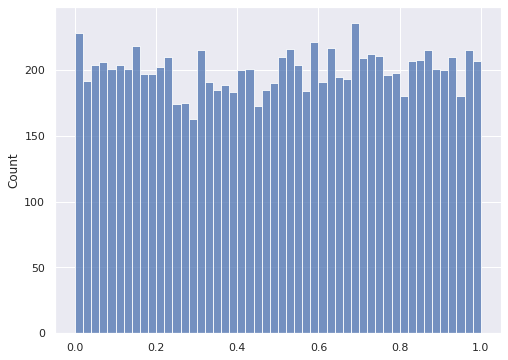

In [9]:
# распределение p-values
sns.set(rc={'figure.figsize':(8, 6)})
sns.histplot(pvalues_dist, 
             kde = False, bins = 50)

Вывод: система сплитовая работает корректно, так как только в ≈ 5 % случаев получены значимые различия между подвыборками при многократном проведении t-тестов (сравнивались подвыборки без повторения из 2 и 3 групп). Равномерность распределения показывает небольшую долю маленьких pvalue (что нам и требовалось). Так как значимых различий между группами в АА-тесте не наблюдается, можно проводить АБ-тест в данных группах.